<a href="https://colab.research.google.com/github/mohamadhabash/Image-Classification-Projects/blob/main/Chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Yahya-Daqour/Chess.git

Cloning into 'Chess'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (577/577), done.
remote: Compressing objects: 100% (560/560), done.
remote: Total 577 (delta 15), reused 576 (delta 15), pack-reused 0
Receiving objects: 100% (577/577), 57.35 MiB | 33.89 MiB/s, done.
Resolving deltas: 100% (15/15), done.


# Dataframe creation
Dataset source: https://www.kaggle.com/niteshfre/chessman-image-dataset

In [ ]:
import pandas as pd

column_names = ['file_name', 'Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

df = pd.DataFrame(columns=column_names)

In [ ]:
from os import walk
from os import rename
import numpy as np

file_names = []
for x in column_names[1:]:
  lst = next(walk(f'/content/Chess/{x}'), (None, None, []))[2]  # [] if no file
  for y in lst:
    file_names.append(y)

len(file_names)

556

In [ ]:
df['file_name'] = file_names

In [ ]:
df = df.fillna(value=0)

In [ ]:
df.head()

,file_name,Bishop,King,Knight,Pawn,Queen,Rook
0,0 (9).jpg,0,0,0,0,0,0
1,0 (15).jpg,0,0,0,0,0,0
2,0 (1).JPG,0,0,0,0,0,0
3,0 (20).jpg,0,0,0,0,0,0
4,0 (21).jpg,0,0,0,0,0,0


In [ ]:
column_names

['file_name', 'Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

In [ ]:
label_dict = {'Bishop':'0', 'King':'1', 'Knight':'2', 'Pawn':'3', 'Queen':'4', 'Rook':'5'}

def create_label(file_name, label):
  if file_name[0] == label_dict[label]:
    return 1
  return 0

for col in column_names[1:]:
  df[col] = df.file_name.apply(create_label, label=col)

In [ ]:
# Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True) # specifying drop=True prevents .reset_index from creating a column containing the old index entries

In [ ]:
df.head()

,file_name,Bishop,King,Knight,Pawn,Queen,Rook
0,5 (12).jpg,0,0,0,0,0,1
1,1 (58).jpg,0,1,0,0,0,0
2,1 (37).jpg,0,1,0,0,0,0
3,3 (7).jpg,0,0,0,1,0,0
4,3 (56).jpg,0,0,0,1,0,0


In [ ]:
df.to_csv('chess.csv')

# Data Preprocess

In [ ]:
df = pd.read_csv('chess.csv', index_col=0)
df.head()

,file_name,Bishop,King,Knight,Pawn,Queen,Rook
0,2 (33).jpg,0,0,1,0,0,0
1,5 (84).JPG,0,0,0,0,0,1
2,5 (82).jpg,0,0,0,0,0,1
3,4 (50).jpg,0,0,0,0,1,0
4,2 (82).jpg,0,0,1,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


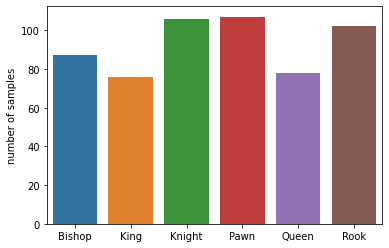

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

column_names = list(df.columns[1:])
labels = df[df.columns[1:]].sum()

bar_plot = sns.barplot(column_names, labels)
plt.ylabel('number of samples')
plt.show()

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
import numpy as np

training_images = []

In [ ]:
label_dict = {v:k for (k,v) in label_dict.items()}
label_dict

{'0': 'Bishop',
 '1': 'King',
 '2': 'Knight',
 '3': 'Pawn',
 '4': 'Queen',
 '5': 'Rook'}

In [ ]:
for image_file in tqdm(df.file_name):
  folder = label_dict[image_file[0]]
  img = load_img(f'/content/Chess/{folder}/{image_file}', target_size=(256,256,3))
  img = img_to_array(img)
  img = (img/255.0).astype(np.float16)
  training_images.append(img)

100%|██████████| 556/556 [00:08<00:00, 62.97it/s]


In [ ]:
training_images = np.array(training_images)
training_images.shape

(556, 256, 256, 3)

In [ ]:
y_train = np.array(df.drop(['file_name'], axis=1))
y_train

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0]])

# Model 

In [ ]:
from keras.applications.xception import Xception
from keras import Model

model = Xception(include_top=False, input_shape=(256,256,3), pooling='avg')

In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
# Freeze parameters
for layer in model.layers:
  layer.trainable = False

In [ ]:
# Add training layers
from keras.layers import Dense, Flatten, Dropout

flat1 = Flatten()(model.layers[-1].output)
fc1 = Dense(256, activation='relu')(flat1)
dropout = Dropout(0.5)(fc1)
output = Dense(6, activation='softmax')(dropout)

model = Model(model.inputs, outputs=output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)
datagen.fit(training_images)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(training_images, y_train, test_size=0.1)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_path = 'best_model.hdf5'

earlystopping_callback = EarlyStopping(monitor='val_accuracy', patience=2)

checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(datagen.flow(X_train, y_train, batch_size=16), 
          epochs=10, 
          validation_data=(X_val, y_val), 
          shuffle=True,
          verbose=1,
          callbacks=[earlystopping_callback, checkpoint_callback])

Epoch 1/10
32/32 [==============================] - 14s 340ms/step - loss: 0.4779 - accuracy: 0.8180 - val_loss: 0.3819 - val_accuracy: 0.8571

Epoch 00001: val_accuracy did not improve from 0.89286
Epoch 2/10
32/32 [==============================] - 10s 309ms/step - loss: 0.4483 - accuracy: 0.8360 - val_loss: 0.3212 - val_accuracy: 0.8929

Epoch 00002: val_accuracy did not improve from 0.89286
Epoch 3/10
32/32 [==============================] - 10s 306ms/step - loss: 0.4426 - accuracy: 0.8520 - val_loss: 0.3192 - val_accuracy: 0.8750

Epoch 00003: val_accuracy did not improve from 0.89286
Epoch 4/10
32/32 [==============================] - 10s 307ms/step - loss: 0.4053 - accuracy: 0.8560 - val_loss: 0.3604 - val_accuracy: 0.8750

Epoch 00004: val_accuracy did not improve from 0.89286


#Evaluate

In [ ]:
# ! gdown --id 1rpDW7HJjCr2h4QRZbHMeCYGfj5sysq6c
# ! gdown --id 1RL67XZaOxsqtjZdYDN50jcHPKi2_jnfJ

Downloading...
From: https://drive.google.com/uc?id=1RL67XZaOxsqtjZdYDN50jcHPKi2_jnfJ
To: /content/12_16_29_775_horse_8_1.jpg
100% 283k/283k [00:00<00:00, 40.6MB/s]


In [ ]:
model.load_weights('/content/best_model.hdf5')

In [ ]:
import urllib.request
from PIL import Image
  
urllib.request.urlretrieve('https://freesvg.org/img/Chess-Knight.png', "Knight.png")


img = load_img('/content/Knight.png', target_size=(256,256,3))

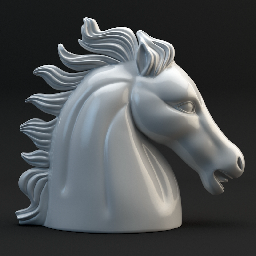

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(np.array(img))

In [ ]:
img = img_to_array(img)
img = (img/255.0).astype(np.float16)

img = img.reshape(1, 256, 256, 3)
predict = model.predict(img)
print(f'predicted label: {label_dict[str(np.argmax(predict, axis=1)[0])]}')

predicted label: Knight
